# week 10 - Information Theory

In [1]:
print("Hello, world!")

Hello, world!


In [2]:
import zlib # Also lzma

text = "Here is some text some text text text with repetition"
print(F"Original text {len(text)} bytes", text)

text_bytes = text.encode('ascii')
comp = zlib.compress(text_bytes)
print(f"Compressed text {len(comp)} bytes", comp)

decomp = zlib.decompress(comp)
print("Decompressed text", decomp.decode('ascii'))

ratio = len(comp) / len(text_bytes)
print(f"Compression ratio: {ratio:.2f}")

Original text 53 bytes Here is some text some text text text with repetition
Compressed text 43 bytes b'x\x9c\xf3H-JU\xc8,V(\xce\xcfMU(I\xad(Ab!\x88\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xd4\x92\xcc\x92\xcc\xfc<\x00\x0c\x82\x13\xfc'
Decompressed text Here is some text some text text text with repetition
Compression ratio: 0.81


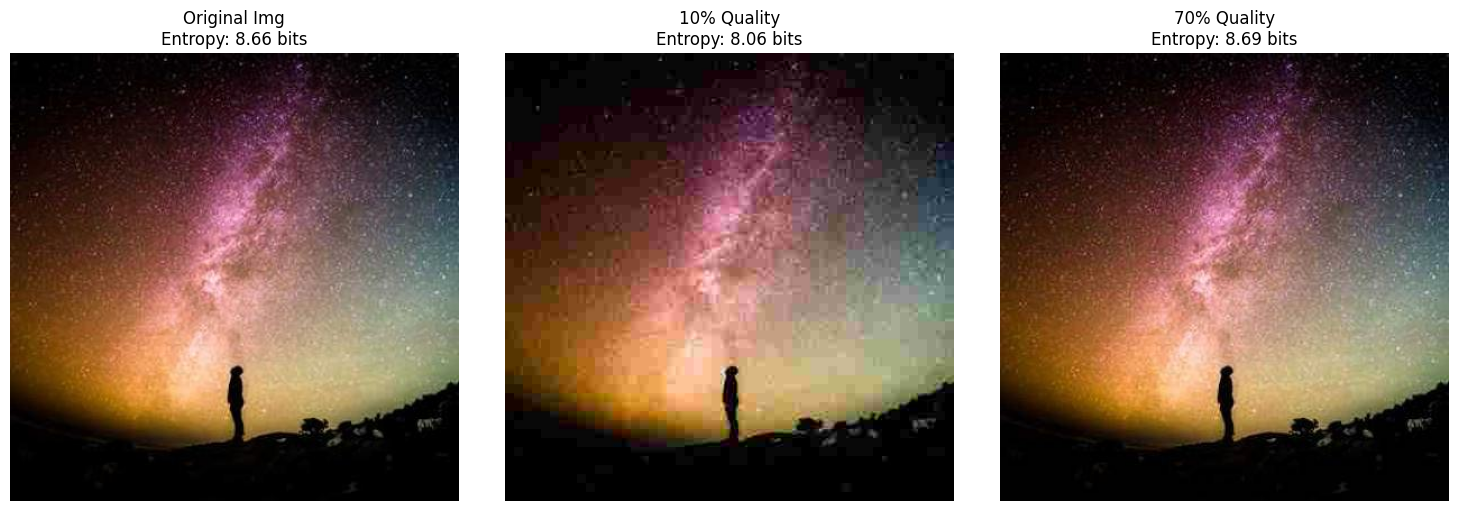

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def entropy(img):
    hist = img.histogram()
    probs = [float(h) / sum(hist) for h in hist]
    return -sum(p * np.log2(p) for p in probs if p != 0)

def compress(img, quality=75):
    fname = f'../images/q_{quality}.jpg'
    img.save(fname, 'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed, entropy(compressed)

url = 'https://picsum.photos/400/400'
response = requests.get(url)
original = Image.open(BytesIO(response.content))

qualities = [10, 70]
images = [original]
entropies = [entropy(original)]
titles = ['Original Img']
for q in qualities:
    img_c, img_h = compress(original, q)
    images.append(img_c)
    entropies.append(img_h)
    titles.append(f'{q}% Quality')

plt.figure(figsize=(15, 5))
for lcv, (img, ent, title) in enumerate(zip(images, entropies, titles), start=1):
    plt.subplot(1, len(images), lcv)
    plt.imshow(img)
    plt.title(f'{title}\nEntropy: {ent:.2f} bits')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Week 11 - Network Simulation

In [4]:
%pip install faker tqdm
from tqdm import tqdm
from queue import Queue
from faker import Faker
from time import time, sleep


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
class Device:
    def __init__(self, name):
        self.ip = ""
        self.name = name
        self.inbox = Queue()

    def send(self, recip, msg):
        print(f"{self.name} is sending {len(msg)} bytes to {recip.ip}")
        for _ in tqdm(range(len(msg)), desc = "Sending", ncols = 100):
            sleep(0.25)
        recip.inbox.put(msg.encode('ascii'))
    
    def recieve(self):
        if not self.inbox.empty():
            msg = self.inbox.get().decode('ascii')
            print(f"{self.name} recieved a message: {msg}")
            return len(msg)
        return 0

In [6]:
class Network:
    def __init__(self):
        self.devices = []
        self.dhcp = Faker()
        self.start_time = time()
        self.usage = 0
        
    def add_device(self, device: Device):
        device.ip = self.dhcp.ipv4()
        self.devices.append(device)

    def sim_traffic(self):
        for device in self.devices:
            self.usage += device.recieve()

    def display(self):
        print(f"Uptime: {time() - self.start_time:.4} seconds")
        print(f"Data usage: {self.usage} bytes")
        print("Connected devices:")
        for d in self.devices:
            print(f"{d.name} \t\t {d.ip}")

In [8]:
alice = Device("Alice")
bob = Device("Bob")

network = Network()
network.add_device(alice)
network.add_device(bob)
network.display()

while True:
    sender_name = input("Who are you (Alice/Bob)?")
    if sender_name == "Alice":
        sender, recip = alice, bob
    elif sender_name == "Bob":
        sender, recip = bob, alice
    else:
        print("Invalid name")
        continue

    msg = input("Enter your message: ")
    sender.send(recip, msg)
    network.sim_traffic()

    loop = input("Do you want to send another message (y/n): ")
    if loop not in "yes":
        break


Uptime: 0.01081 seconds
Data usage: 0 bytes
Connected devices:
Alice 		 146.49.169.84
Bob 		 147.149.220.120
Bob is sending 14 bytes to 146.49.169.84


Sending: 100%|██████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.98it/s]


Alice recieved a message: my name is bob
Invalid name
Invalid name
Invalid name
Invalid name
Bob is sending 9 bytes to 146.49.169.84


Sending: 100%|████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.99it/s]


Alice recieved a message: bye alice


# Week 12 - TCP-IP Model

In [4]:
%pip install faker tqdm termcolor -q
import random
from tqdm import tqdm
from time import sleep
from faker import Faker
from termcolor import colored


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
def print_sleep(msg, seconds=1):
    print(msg)
    sleep(seconds)

def do_progress(length, desc, seconds=0.05):
    for _ in tqdm(range(length), desc=desc, mcols = 100):
        sleep(seconds)

In [6]:
class ApplicationLayer:
    def __init__(self, data):
        self.data = data

    def prepare_data(self):
        print_sleep(colored("Application Layer: ", "cyan") + f"Preparing data '{self.data}'")
        return self.data.encode()
class TransportLayer:
    def __init__(self, protocol="TCP", port=80):
        self.protocol = protocol
        self.port = port
        self.sequence_number = random.randint(1, 1000)

    def prepare_segment(self, data):
        header = colored("Transport Layer: ", "magenta")
        if self.protocol == "TCP":
            print_sleep(header + f"Using TCP on Port {self.port} - Establishing connection...")
            print_sleep(header + f"SYN packet (Seq={self.sequence_number})", 0.5)
            print_sleep(header + f"SYN-ACK packet (Seq={self.sequence_number+1})", 0.5)
            print_sleep(header + f"ACK packet - Connection established!", 0.5)
        else:
            print(header + f"Using UDP on Port {self.port} - No connection setup required.")
        
        segment = f"{self.protocol}-Port-{self.port}-Segment-{self.sequence_number}|{data.decode()}"
        do_progress(len(segment), "Transport Layer Processing")
        return segment.encode()

class InternetLayer:
    def __init__(self, src_ip, dest_ip):
        self.src_ip = src_ip
        self.dest_ip = dest_ip

    def prepare_packet(self, segment):
        print_sleep(colored("InternetLayer: ", "yellow") + f"Adding IP Header (Source: {self.src_ip}, Destination: {self.dest_ip})")
        packet = f"IP:{self.src_ip}>{self.dest_ip}|{segment.decode()}"
        do_progress(len(packet), "Internet Layer Processing")
        return packet.encode()

class NetworkAccessLayer:
    def __init__(self, src_mac, dest_mac):
        self.src_mac = src_mac
        self.dest_mac = dest_mac

    def prepare_frame(self, packet):
        print_sleep(colored("InternetLayer: ", "green") + f"Adding MAC Header (Source: {self.src_mac}, Destination: {self.dest_mac})")
        frame = f"MAC:{self.src_mac}>{self.dest_mac}|{packet.decode()}"
        do_progress(len(frame), "Network Access Layer Processing")
        return frame.encode()


In [7]:
class InternetDevice:
    def __init__(self, name, ip, mac):
        self.name = name
        self.ip = ip
        self.mac = mac

    def send(self, dest_device, data, port=80):
        app_data = ApplicationLayer(data).prepare_data()
        segment = TransportLayer("TCP").prepare_segment(app_data)
        packet = InternetLayer(self.ip, dest_device.ip).prepare_packet(segment)
        frame = NetworkAccessLayer(self.mac, dest_device.mac).prepare_frame(packet)
        print_sleep(f"\n{self.name} is sending data to {dest_device.name} on port {port}")
        dest_device.recieve(frame)

    def recieve(self, frame):
        print(f"{self.name} recieved data: \n{frame.decode()}\n")
        print("Processing data through layers...")
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        split_frame = frame.decode().split("|")
        del split_frame[0]
        do_progress(5, "Internet Layer Decapsulation", 0.1)
        del split_frame[0]
        do_progress(5, "Transport Layer Decapsulation", 0.1)
        del split_frame[0]
        do_progress(5, "Application Layer Decapsulation", 0.1)
        print(f"\nData recieved:\n{split_frame[0]}")

In [8]:
 router = Faker()
 device1 = InternetDevice("ComputerA", router.ipv4(), router.mac_address())
 device2 = InternetDevice("ComputerB", router.ipv4(), router.mac_address())
 device1.send(device2, "Hello from ComputerA!", port=80)

Application Layer: Preparing data 'Hello from ComputerA!'
Transport Layer: Using TCP on Port 80 - Establishing connection...
Transport Layer: SYN packet (Seq=657)
Transport Layer: SYN-ACK packet (Seq=658)
Transport Layer: ACK packet - Connection established!


TqdmKeyError: "Unknown argument(s): {'mcols': 100}"

# Week 13 - Encryption

In [1]:
%pip install sympy -q
import sympy

class RSA:
    def __init__(self, p=-1, q=-1):
        p = sympy.randprime(500, 1_000_000) if p == -1 else p
        q = sympy.randprime(500, 1_000_000) if q == -1 else q
        self.n = p *q
        self.phi = (p-1) * (q-1)
        self.e = 2
        while sympy.gcd(self.e, self.phi) != 1:
            self.e += 1
        self.d = pow(self.e, -1, self.phi)

    def encrypt(self, msg):
        cipher = [pow(ord(m), self.e, self.n) for m in msg]
        return cipher

    def decrypt(self, cipher):
        msg = "".join([chr(pow(c, self.e, self.n))for c in cipher]) 
        return msg


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import base64
import numpy as np

rsa = RSA(p=61, q=53)

message = input("Enter a message: ")
print("Entered ", message)

e_msg = rsa.encrypt(message)
print("Encrypted message: ", e_msg)
print("Encrypted (base64):", base64.b64encode(np.array(e_msg)))

d_msg = rsa.decrypt(e_msg)
print("Decrypted message:", d_msg)

Entered  Hello, world
Encrypted message:  [1087, 3071, 1877, 1877, 3183, 1129, 2774, 863, 3183, 1797, 1877, 2872]
Encrypted (base64): b'PwQAAAAAAAD/CwAAAAAAAFUHAAAAAAAAVQcAAAAAAABvDAAAAAAAAGkEAAAAAAAA1goAAAAAAABfAwAAAAAAAG8MAAAAAAAABQcAAAAAAABVBwAAAAAAADgLAAAAAAAA'
Decrypted message: Иࠅ੮੮հ͌őϤհɹ੮௚


# Week 14 - Quantum Computing

In [2]:
%pip install qiskit qiskit.aer -q
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector

Note: you may need to restart the kernel to use updated packages.


Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


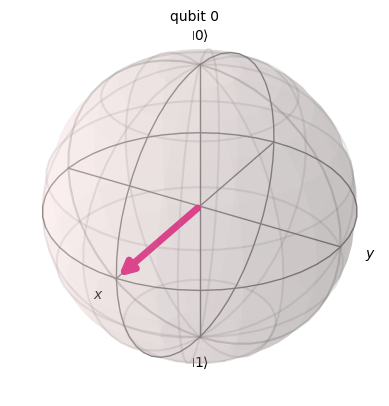

In [5]:
qc = QuantumCircuit(1, 1)

qc.h(0)

qc.save_statevector()
sim = AerSimulator()
qobj = transpile(qc, sim)
result = sim.run(qobj).result()
statevector = result.get_statevector()
print(statevector)
plot_bloch_multivector(statevector)

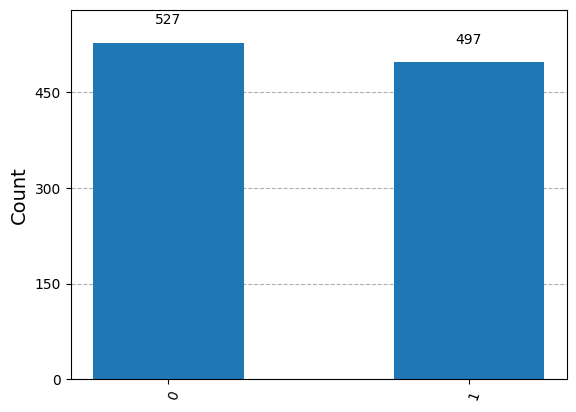

In [7]:
qc.measure([0], [0])
counts = sim.run(qc).result().get_counts()
plot_histogram(counts)

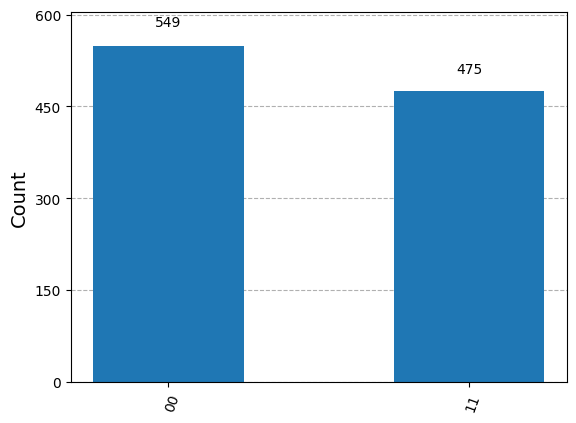

In [8]:
qc_entangle = QuantumCircuit(2, 2)

qc_entangle.h(0)
qc_entangle.cx(0, 1)
qc_entangle.measure([0, 1], [0, 1])

qc_entangle.save_statevector()
sim_result = sim.run(qc_entangle).result()
counts = sim_result.get_counts()
plot_histogram(counts)


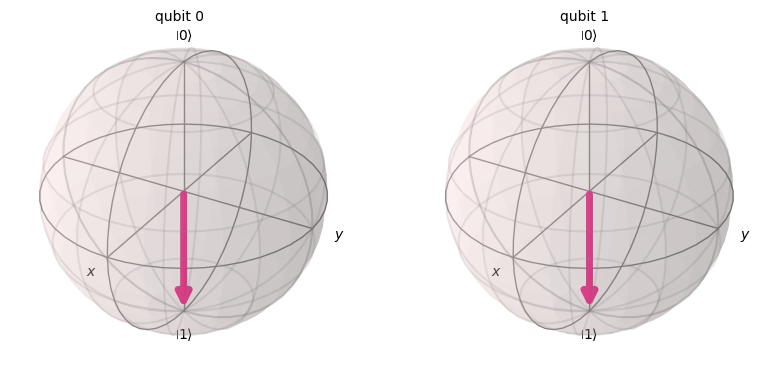

In [9]:
statevectors = sim_result.get_statevector()
plot_bloch_multivector(statevectors)

## Week 21 - SQL

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("prog54a.db")
cur = conn.cursor()

In [2]:
cur.execute("""
CREATE TABLE cars (
    Vehicle TEXT,
    Miles INT,
    Gallons INT,
    MPG FLOAT  
)
""")

In [3]:
data = [
    ('1970 VW Bug', 286, 9),
    ('1979 Firebird', 412, 40),
    ('1980 Subaru', 361, 18),
    ('1975 Cutlass', 161, 11)
]
cur.executemany('INSERT INTO cars (Vehicle, Miles, Gallons, MPG) VALUES (?, ?, ?, 0)', data)
conn.commit()

In [4]:
df = pd.read_sql_query('SELECT * FROM cars', conn)
df

,Vehicle,Miles,Gallons,MPG
0,1970 VW Bug,286,9,0.0
1,1979 Firebird,412,40,0.0
2,1980 Subaru,361,18,0.0
3,1975 Cutlass,161,11,0.0


In [5]:
for index, row in df.iterrows():
    mpg = round(row['Miles'] / row['Gallons'], 1)
    cur.execute('UPDATE cars SET MPG = ? WHERE Vehicle = ?', (mpg, row['Vehicle']))
cur.execute('DELETE FROM cars WHERE MPG < 12 AND Gallons = 40')
conn.commit()

In [6]:
updated_df = pd.read_sql_query('SELECT * FROM cars', conn)
cur.close()
conn.close()
updated_df

,Vehicle,Miles,Gallons,MPG
0,1970 VW Bug,286,9,31.8
1,1980 Subaru,361,18,20.1
2,1975 Cutlass,161,11,14.6


/tmp/ipykernel_4249/3119368437.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['Miles'], y = df['Vehicle'], palette='viridis')


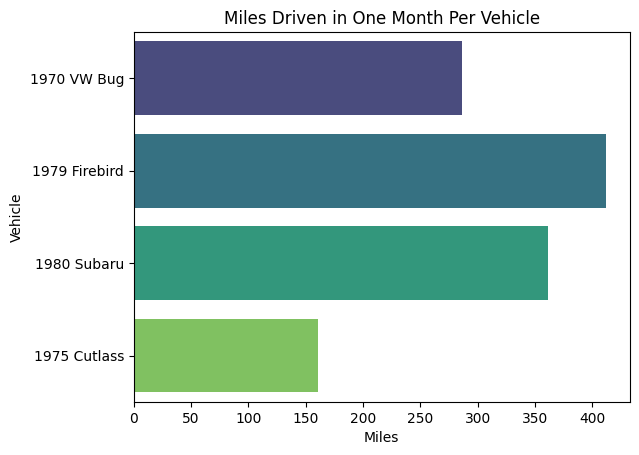

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(x=df['Miles'], y = df['Vehicle'], palette='viridis')
plt.title('Miles Driven in One Month Per Vehicle')
plt.show()

## Week 21 - AI/Machine Learning

In [1]:
%pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_csv("../data/gapminder.csv").sort_values(by="life_expectancy", ascending=False)
df

,Unnamed: 0,country,continent,year,life_expectancy,population,gdp_per_capita
0,0,Japan,Asia,2007-01-01,82.603,127467972,31656.068060
1,1,"Hong Kong, China",Asia,2007-01-01,82.208,6980412,39724.978670
2,2,Japan,Asia,2002-01-01,82.000,127065841,28604.591900
3,3,Iceland,Europe,2007-01-01,81.757,301931,36180.789190
4,4,Switzerland,Europe,2007-01-01,81.701,7554661,37506.419070
...,...,...,...,...,...,...,...
1699,1699,Sierra Leone,Africa,1952-01-01,30.331,2143249,879.787736
1700,1700,Angola,Africa,1952-01-01,30.015,4232095,3520.610273
1701,1701,Gambia,Africa,1952-01-01,30.000,284320,485.230659
1702,1702,Afghanistan,Asia,1952-01-01,28.801,8425333,779.445314


In [5]:
df['year'] = pd.to_datetime(df['year'])
df = df[df['year'].dt.year == 1997]

correlation = df['life_expectancy'].corr(df['gdp_per_capita'])
print("Correlation:", correlation)

Correlation: 0.7036435851888246


In [6]:
X = df[['gdp_per_capita']]
y = df['life_expectancy']

model = LinearRegression()
model.fit(X, y)
print("Score:", model.score(X, y))

Score: 0.49511429497738324


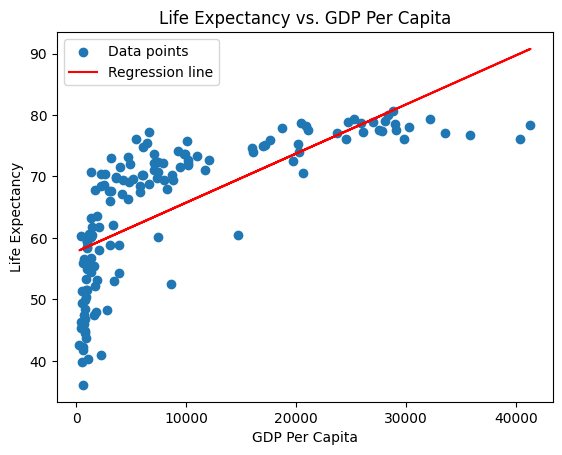

US predicted life expectancy in 1998: [84.0173661]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [7]:
plt.scatter(X, y, label='Data points')
plt.plot(X, model.predict(X), color='red', label='Regression line')
plt.xlabel('GDP Per Capita')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy vs. GDP Per Capita')
plt.legend()
plt.show()
print("US predicted life expectancy in 1998:", model.predict([[32853.67]]))